In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
from model import FullModelInCode, FullModelInPaper, FullModel
from dataset import BodyMeasurementDataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

## Load dataset and model

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

training_set = BodyMeasurementDataset("train_female.h5")
training_loader = DataLoader(training_set, batch_size=32, shuffle=True)
validate_set = BodyMeasurementDataset("validate_female.h5")
validate_loader = DataLoader(validate_set, batch_size=16, shuffle=True)
# model_in_code = FullModelInCode()
# model_in_paper = FullModelInPaper()
model = FullModel()

## show samples of dataset

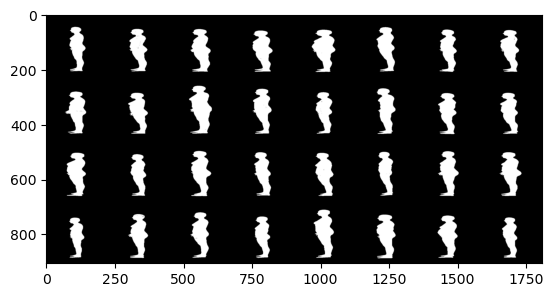

In [3]:
def showimg(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
fronts, sides, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(fronts)
showimg(img_grid)
img_grid = torchvision.utils.make_grid(sides)
showimg(img_grid)

## Train model

In [4]:
def train_one_epoch(model, dataloader, optimizer, device, epoch_index, tb_writer, write_every=5):
    running_loss = 0.0
    all_loss = 0.0
    
    for i, data in tqdm(enumerate(dataloader)):
        fronts, sides, labels = data
        fronts, sides, labels = fronts.to(device), sides.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(fronts, sides)
        loss = torch.nn.functional.mse_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss = loss.item()
        all_loss += running_loss
        if i % write_every == write_every - 1:
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', running_loss, tb_x)
            # print('  epoch: {} batch: {} loss: {}'.format(epoch_index, i, running_loss))
    
    return all_loss / len(dataloader)

def train(model, train_dataloader, validate_dataloader, device, lr=0.001, write_every=10, epochs=150):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/model_{}'.format(timestamp))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    epoch_number = 0
    best_vloss = 1_000_000.

    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(model, train_dataloader, optimizer, device, epoch_number, writer)

        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validate_dataloader):
                vfronts, vsides, vlabels = vdata
                vfronts, vsides, vlabels = vfronts.to(device), vsides.to(device), vlabels.to(device)
                voutputs = model(vfronts, vsides)
                vloss = torch.nn.functional.mse_loss(voutputs, vlabels)
                running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model/model_{}_{}.ckpt'.format(timestamp, epoch_number)
            torch.save(model.state_dict(), model_path)

        epoch_number += 1

## Train model (from scratch)

In [5]:
train(model, training_loader, validate_loader, device)

EPOCH 1:


52it [00:03, 17.09it/s]


LOSS train 991531.9116210938 valid 13107.359375
EPOCH 2:


52it [00:02, 20.21it/s]


LOSS train 6004.374051607572 valid 3668.069091796875
EPOCH 3:


52it [00:02, 20.39it/s]


LOSS train 4794.095196063702 valid 4092.6318359375
EPOCH 4:


52it [00:02, 20.44it/s]


LOSS train 4957.5676504281855 valid 3658.555419921875
EPOCH 5:


52it [00:02, 20.21it/s]


LOSS train 4891.283287635217 valid 5657.931640625
EPOCH 6:


52it [00:02, 20.11it/s]


LOSS train 5316.163893479567 valid 8789.078125
EPOCH 7:


52it [00:02, 20.27it/s]


LOSS train 5924.191856971154 valid 5830.86962890625
EPOCH 8:


52it [00:02, 20.25it/s]


LOSS train 5855.27769118089 valid 4706.58349609375
EPOCH 9:


52it [00:02, 20.16it/s]


LOSS train 4776.993239182692 valid 6732.93017578125
EPOCH 10:


52it [00:02, 20.11it/s]


LOSS train 4847.269836425781 valid 4044.19482421875
EPOCH 11:


52it [00:02, 20.25it/s]


LOSS train 4885.497755784255 valid 3378.495849609375
EPOCH 12:


52it [00:02, 20.41it/s]


LOSS train 4639.893258901743 valid 3629.091552734375
EPOCH 13:


52it [00:02, 20.43it/s]


LOSS train 4735.4072500375605 valid 4328.72412109375
EPOCH 14:


52it [00:02, 20.21it/s]


LOSS train 4585.99428147536 valid 4629.5849609375
EPOCH 15:


52it [00:02, 20.20it/s]


LOSS train 5365.675058218149 valid 7955.15673828125
EPOCH 16:


52it [00:02, 20.15it/s]


LOSS train 5522.9768301156855 valid 3195.885498046875
EPOCH 17:


52it [00:02, 20.32it/s]


LOSS train 4478.837529109074 valid 3689.7431640625
EPOCH 18:


52it [00:02, 20.31it/s]


LOSS train 4873.550546499399 valid 3382.94482421875
EPOCH 19:


52it [00:02, 20.38it/s]


LOSS train 4471.755211463342 valid 3931.840576171875
EPOCH 20:


52it [00:02, 20.40it/s]


LOSS train 4446.415395883413 valid 4571.69482421875
EPOCH 21:


52it [00:02, 20.35it/s]


LOSS train 4699.115411611704 valid 3512.57421875
EPOCH 22:


52it [00:02, 20.38it/s]


LOSS train 4452.705251840444 valid 3496.056640625
EPOCH 23:


52it [00:02, 20.35it/s]


LOSS train 4624.289569561298 valid 4689.68994140625
EPOCH 24:


52it [00:02, 20.44it/s]


LOSS train 4663.170903132512 valid 4549.99853515625
EPOCH 25:


52it [00:02, 20.44it/s]


LOSS train 4806.2387460561895 valid 3168.703369140625
EPOCH 26:


52it [00:02, 20.26it/s]


LOSS train 5563.679063063401 valid 6427.80908203125
EPOCH 27:


52it [00:02, 20.31it/s]


LOSS train 4723.399921123798 valid 3613.3984375
EPOCH 28:


52it [00:02, 20.06it/s]


LOSS train 4482.295029860276 valid 3680.390625
EPOCH 29:


52it [00:02, 20.39it/s]


LOSS train 4821.9031982421875 valid 3210.181640625
EPOCH 30:


52it [00:02, 20.20it/s]


LOSS train 4275.024977463942 valid 3310.670654296875
EPOCH 31:


52it [00:02, 20.18it/s]


LOSS train 4664.8238196739785 valid 3188.513916015625
EPOCH 32:


52it [00:02, 20.20it/s]


LOSS train 4377.638502854567 valid 8593.4677734375
EPOCH 33:


52it [00:02, 20.38it/s]


LOSS train 4751.258155235877 valid 12983.2646484375
EPOCH 34:


52it [00:02, 20.42it/s]


LOSS train 5536.646165114183 valid 3120.841552734375
EPOCH 35:


52it [00:02, 20.38it/s]


LOSS train 4202.072715759277 valid 3873.040771484375
EPOCH 36:


52it [00:02, 20.42it/s]


LOSS train 4527.609544020433 valid 6918.6142578125
EPOCH 37:


52it [00:02, 20.33it/s]


LOSS train 5026.6083092322715 valid 3254.559326171875
EPOCH 38:


52it [00:02, 20.41it/s]


LOSS train 3788.4352064866284 valid 3907.81201171875
EPOCH 39:


52it [00:02, 20.36it/s]


LOSS train 3997.6643500694863 valid 2864.556396484375
EPOCH 40:


52it [00:02, 20.21it/s]


LOSS train 3924.371157132662 valid 4691.54296875
EPOCH 41:


52it [00:02, 20.27it/s]


LOSS train 3608.8384141188403 valid 2742.45458984375
EPOCH 42:


52it [00:02, 20.18it/s]


LOSS train 3597.313978928786 valid 4746.8505859375
EPOCH 43:


52it [00:02, 20.27it/s]


LOSS train 3619.070073054387 valid 4822.40234375
EPOCH 44:


52it [00:02, 20.25it/s]


LOSS train 3618.847348726713 valid 3950.650634765625
EPOCH 45:


52it [00:02, 20.33it/s]


LOSS train 3757.740215594952 valid 3448.54345703125
EPOCH 46:


52it [00:02, 20.44it/s]


LOSS train 3397.921560434195 valid 5070.607421875
EPOCH 47:


52it [00:02, 20.42it/s]


LOSS train 3643.20993746244 valid 2225.200439453125
EPOCH 48:


52it [00:02, 20.39it/s]


LOSS train 3325.2024512657754 valid 7378.9482421875
EPOCH 49:


52it [00:02, 20.40it/s]


LOSS train 3586.98386324369 valid 3897.31298828125
EPOCH 50:


52it [00:02, 20.32it/s]


LOSS train 3849.2569838303784 valid 2798.993896484375
EPOCH 51:


52it [00:02, 20.42it/s]


LOSS train 3186.158881554237 valid 2132.654296875
EPOCH 52:


52it [00:02, 20.41it/s]


LOSS train 3354.1162719726562 valid 2494.513427734375
EPOCH 53:


52it [00:02, 20.39it/s]


LOSS train 3441.8279395470254 valid 3318.11279296875
EPOCH 54:


52it [00:02, 20.38it/s]


LOSS train 3101.6557171161357 valid 2169.5908203125
EPOCH 55:


52it [00:02, 20.20it/s]


LOSS train 3075.218552809495 valid 2134.353515625
EPOCH 56:


52it [00:02, 20.08it/s]


LOSS train 3050.51457801232 valid 3601.531982421875
EPOCH 57:


52it [00:02, 20.29it/s]


LOSS train 2936.787142240084 valid 2908.89013671875
EPOCH 58:


52it [00:02, 20.16it/s]


LOSS train 2803.0906583345854 valid 2556.460693359375
EPOCH 59:


52it [00:02, 20.20it/s]


LOSS train 2689.959897554838 valid 2052.62451171875
EPOCH 60:


52it [00:02, 20.15it/s]


LOSS train 2298.1985755333535 valid 1659.9383544921875
EPOCH 61:


52it [00:02, 20.29it/s]


LOSS train 2526.1688232421875 valid 1475.7412109375
EPOCH 62:


52it [00:02, 20.35it/s]


LOSS train 2216.8602224496694 valid 4297.546875
EPOCH 63:


52it [00:02, 20.41it/s]


LOSS train 2405.4903517503003 valid 2132.62255859375
EPOCH 64:


52it [00:02, 20.35it/s]


LOSS train 2433.3715397761416 valid 9313.4296875
EPOCH 65:


52it [00:02, 20.48it/s]


LOSS train 3572.494880089393 valid 2646.31005859375
EPOCH 66:


52it [00:02, 20.20it/s]


LOSS train 2324.3121314415566 valid 2219.80029296875
EPOCH 67:


52it [00:02, 20.17it/s]


LOSS train 2288.329045222356 valid 1633.774169921875
EPOCH 68:


52it [00:02, 20.15it/s]


LOSS train 2208.9543011005107 valid 7245.08251953125
EPOCH 69:


52it [00:02, 20.20it/s]


LOSS train 3357.562534038837 valid 5452.099609375
EPOCH 70:


52it [00:02, 20.29it/s]


LOSS train 2683.5936255821816 valid 1786.8065185546875
EPOCH 71:


52it [00:02, 20.25it/s]


LOSS train 2162.212353046124 valid 3107.23974609375
EPOCH 72:


52it [00:02, 20.28it/s]


LOSS train 2740.80419921875 valid 1389.1280517578125
EPOCH 73:


52it [00:02, 20.16it/s]


LOSS train 2170.4591040978066 valid 1926.620361328125
EPOCH 74:


52it [00:02, 20.25it/s]


LOSS train 2216.4605689415566 valid 1322.0999755859375
EPOCH 75:


52it [00:02, 20.20it/s]


LOSS train 2071.0599553034854 valid 1197.1832275390625
EPOCH 76:


52it [00:02, 20.20it/s]


LOSS train 2270.29441011869 valid 7878.34716796875
EPOCH 77:


52it [00:02, 20.24it/s]


LOSS train 2808.316395686223 valid 1375.9058837890625
EPOCH 78:


52it [00:02, 20.25it/s]


LOSS train 2167.983891413762 valid 1208.4862060546875
EPOCH 79:


52it [00:02, 20.28it/s]


LOSS train 2323.4805462176982 valid 1613.228759765625
EPOCH 80:


52it [00:02, 20.24it/s]


LOSS train 2198.9566720815806 valid 2771.836669921875
EPOCH 81:


52it [00:02, 20.22it/s]


LOSS train 2524.2339947040264 valid 1382.1473388671875
EPOCH 82:


52it [00:02, 20.24it/s]


LOSS train 2250.150179349459 valid 1396.857177734375
EPOCH 83:


52it [00:02, 20.23it/s]


LOSS train 2208.628223125751 valid 2767.72998046875
EPOCH 84:


52it [00:02, 20.22it/s]


LOSS train 2308.6280447152944 valid 1120.935546875
EPOCH 85:


52it [00:02, 20.23it/s]


LOSS train 2263.7815387432393 valid 3186.76953125
EPOCH 86:


52it [00:02, 20.29it/s]


LOSS train 2251.2014934833232 valid 3054.607177734375
EPOCH 87:


52it [00:02, 20.25it/s]


LOSS train 2197.225588285006 valid 1445.476318359375
EPOCH 88:


52it [00:02, 20.22it/s]


LOSS train 2061.5702021672178 valid 3962.093994140625
EPOCH 89:


52it [00:02, 20.23it/s]


LOSS train 2307.730241041917 valid 3001.815185546875
EPOCH 90:


52it [00:02, 20.28it/s]


LOSS train 2117.438004713792 valid 1402.5904541015625
EPOCH 91:


52it [00:02, 20.22it/s]


LOSS train 2147.9867201585034 valid 1148.144775390625
EPOCH 92:


52it [00:02, 20.28it/s]


LOSS train 2161.4807574932393 valid 2166.165771484375
EPOCH 93:


52it [00:02, 20.24it/s]


LOSS train 2339.7586176945615 valid 1276.202392578125
EPOCH 94:


52it [00:02, 20.33it/s]


LOSS train 2073.5207073505107 valid 1409.2169189453125
EPOCH 95:


52it [00:02, 20.29it/s]


LOSS train 2159.1183636005107 valid 5848.0380859375
EPOCH 96:


52it [00:02, 20.27it/s]


LOSS train 2722.5682513897236 valid 3660.74853515625
EPOCH 97:


52it [00:02, 20.34it/s]


LOSS train 2676.295400766226 valid 1304.1617431640625
EPOCH 98:


52it [00:02, 20.17it/s]


LOSS train 2081.9766798753003 valid 1116.185302734375
EPOCH 99:


52it [00:02, 20.25it/s]


LOSS train 2076.501654991737 valid 3602.434814453125
EPOCH 100:


52it [00:02, 20.18it/s]


LOSS train 2388.132601224459 valid 1501.6728515625
EPOCH 101:


52it [00:02, 20.36it/s]


LOSS train 1999.6778001051682 valid 1403.5611572265625
EPOCH 102:


52it [00:02, 20.26it/s]


LOSS train 2069.7166536771333 valid 2325.1826171875
EPOCH 103:


52it [00:02, 20.43it/s]


LOSS train 2199.7791853684644 valid 1425.61376953125
EPOCH 104:


52it [00:02, 20.44it/s]


LOSS train 1964.9149052546575 valid 1257.3382568359375
EPOCH 105:


52it [00:02, 20.41it/s]


LOSS train 1940.6546842134917 valid 1629.1844482421875
EPOCH 106:


52it [00:02, 20.32it/s]


LOSS train 2062.9314539982724 valid 1225.0245361328125
EPOCH 107:


52it [00:02, 20.33it/s]


LOSS train 2049.1550809420073 valid 2363.223388671875
EPOCH 108:


52it [00:02, 20.39it/s]


LOSS train 2230.3546424278848 valid 1631.5369873046875
EPOCH 109:


52it [00:02, 20.42it/s]


LOSS train 1965.4368720421423 valid 2667.1845703125
EPOCH 110:


52it [00:02, 20.40it/s]


LOSS train 2116.1864577073316 valid 1839.8004150390625
EPOCH 111:


52it [00:02, 20.35it/s]


LOSS train 2312.481698843149 valid 3340.420166015625
EPOCH 112:


52it [00:02, 20.34it/s]


LOSS train 2243.3635371281553 valid 1270.870849609375
EPOCH 113:


52it [00:02, 20.26it/s]


LOSS train 1977.9536578838643 valid 2013.876953125
EPOCH 114:


52it [00:02, 20.24it/s]


LOSS train 2015.1059992863582 valid 1325.14697265625
EPOCH 115:


52it [00:02, 20.32it/s]


LOSS train 2070.784879244291 valid 1878.25
EPOCH 116:


52it [00:02, 20.12it/s]


LOSS train 2353.7193392240083 valid 1490.41357421875
EPOCH 117:


52it [00:02, 20.25it/s]


LOSS train 1930.137714092548 valid 1105.895751953125
EPOCH 118:


52it [00:02, 20.41it/s]


LOSS train 1958.9783947284404 valid 1251.58740234375
EPOCH 119:


52it [00:02, 20.26it/s]


LOSS train 1928.5281483576848 valid 1129.8331298828125
EPOCH 120:


52it [00:02, 20.11it/s]


LOSS train 1893.2895953838643 valid 1124.5745849609375
EPOCH 121:


52it [00:02, 20.23it/s]


LOSS train 1882.59915630634 valid 1367.6165771484375
EPOCH 122:


52it [00:02, 20.21it/s]


LOSS train 1999.116171029898 valid 1506.42236328125
EPOCH 123:


52it [00:02, 20.18it/s]


LOSS train 2077.666055532602 valid 1810.9317626953125
EPOCH 124:


52it [00:02, 20.21it/s]


LOSS train 1970.015842144306 valid 1432.315673828125
EPOCH 125:


52it [00:02, 20.15it/s]


LOSS train 1865.2568030724158 valid 3246.998046875
EPOCH 126:


52it [00:02, 20.15it/s]


LOSS train 2196.6068749060996 valid 1911.9144287109375
EPOCH 127:


52it [00:02, 20.12it/s]


LOSS train 2036.0460322453425 valid 1329.2037353515625
EPOCH 128:


52it [00:02, 20.23it/s]


LOSS train 1897.1270329402043 valid 2688.7626953125
EPOCH 129:


52it [00:02, 20.37it/s]


LOSS train 2283.343754695012 valid 1903.4874267578125
EPOCH 130:


52it [00:02, 20.25it/s]


LOSS train 1933.0970294658955 valid 1344.6986083984375
EPOCH 131:


52it [00:02, 20.14it/s]


LOSS train 1783.1311692457932 valid 1198.79150390625
EPOCH 132:


52it [00:02, 20.30it/s]


LOSS train 1787.3805272028997 valid 1133.140380859375
EPOCH 133:


52it [00:02, 20.32it/s]


LOSS train 1865.395758995643 valid 1197.876220703125
EPOCH 134:


52it [00:02, 20.04it/s]


LOSS train 1950.4090012770432 valid 1448.102783203125
EPOCH 135:


52it [00:02, 20.20it/s]


LOSS train 1816.5453139085037 valid 1471.556396484375
EPOCH 136:


52it [00:02, 20.23it/s]


LOSS train 1868.6100135216345 valid 1116.572998046875
EPOCH 137:


52it [00:02, 20.24it/s]


LOSS train 1794.1487520658052 valid 1196.46435546875
EPOCH 138:


52it [00:02, 20.34it/s]


LOSS train 1804.577377319336 valid 1582.719482421875
EPOCH 139:


52it [00:02, 20.41it/s]


LOSS train 1966.8330782376802 valid 1038.863037109375
EPOCH 140:


52it [00:02, 20.44it/s]


LOSS train 1794.5595233623799 valid 1180.632568359375
EPOCH 141:


52it [00:02, 20.22it/s]


LOSS train 1848.8714775672327 valid 1099.6177978515625
EPOCH 142:


52it [00:02, 20.18it/s]


LOSS train 1794.503162090595 valid 1987.8765869140625
EPOCH 143:


52it [00:02, 20.27it/s]


LOSS train 1843.853517972506 valid 1455.9287109375
EPOCH 144:


52it [00:02, 20.44it/s]


LOSS train 1851.647939828726 valid 2105.690185546875
EPOCH 145:


52it [00:02, 20.18it/s]


LOSS train 1985.7952927809495 valid 1072.482177734375
EPOCH 146:


52it [00:02, 20.21it/s]


LOSS train 1873.4259103628306 valid 3012.37158203125
EPOCH 147:


52it [00:02, 20.09it/s]


LOSS train 2170.285869891827 valid 1365.521728515625
EPOCH 148:


52it [00:02, 20.13it/s]


LOSS train 1901.7849743182842 valid 1333.5333251953125
EPOCH 149:


52it [00:02, 20.18it/s]


LOSS train 1935.5787306565505 valid 1919.9537353515625
EPOCH 150:


52it [00:02, 20.27it/s]


LOSS train 1905.1987562913162 valid 2309.150146484375


In [17]:
# train from a checkpoint
model = FullModel()
model.load_state_dict(torch.load('model/model_20231028_220313_138.ckpt'))
train(model, training_loader, validate_loader, device, lr=0.0001, epochs=200)

EPOCH 1:


52it [00:02, 19.84it/s]


LOSS train 1770.8089364858774 valid 969.5173950195312
EPOCH 2:


52it [00:02, 20.26it/s]


LOSS train 1773.4014540452224 valid 977.6890869140625
EPOCH 3:


52it [00:02, 20.16it/s]


LOSS train 1939.1542287973257 valid 1215.978759765625
EPOCH 4:


52it [00:02, 20.17it/s]


LOSS train 1814.3472524789663 valid 966.5574951171875
EPOCH 5:


52it [00:02, 20.30it/s]


LOSS train 1747.453340970553 valid 1085.144775390625
EPOCH 6:


52it [00:02, 20.25it/s]


LOSS train 1841.2329107431265 valid 1013.9202880859375
EPOCH 7:


52it [00:02, 20.34it/s]


LOSS train 1744.9454204852764 valid 999.0010986328125
EPOCH 8:


52it [00:02, 20.32it/s]


LOSS train 1823.3716242863582 valid 1175.4488525390625
EPOCH 9:


52it [00:02, 20.39it/s]


LOSS train 1771.110856276292 valid 1052.673583984375
EPOCH 10:


52it [00:02, 20.55it/s]


LOSS train 1843.665010892428 valid 1150.0123291015625
EPOCH 11:


52it [00:02, 20.54it/s]


LOSS train 1835.3177795410156 valid 966.7637329101562
EPOCH 12:


52it [00:02, 20.54it/s]


LOSS train 1777.1988971416768 valid 991.791015625
EPOCH 13:


52it [00:02, 20.50it/s]


LOSS train 1865.5619753324067 valid 1751.269287109375
EPOCH 14:


52it [00:02, 20.55it/s]


LOSS train 1817.0492013784556 valid 1505.5416259765625
EPOCH 15:


52it [00:02, 20.54it/s]


LOSS train 1914.7827758789062 valid 959.5191040039062
EPOCH 16:


52it [00:02, 20.47it/s]


LOSS train 1732.7902080829326 valid 1047.6517333984375
EPOCH 17:


52it [00:02, 20.47it/s]


LOSS train 1915.0766906738281 valid 1667.555419921875
EPOCH 18:


52it [00:02, 20.50it/s]


LOSS train 2220.1368936391978 valid 1057.9783935546875
EPOCH 19:


52it [00:02, 20.35it/s]


LOSS train 1764.908436701848 valid 987.8963012695312
EPOCH 20:


52it [00:02, 20.27it/s]


LOSS train 1765.0927006648137 valid 1057.0340576171875
EPOCH 21:


52it [00:02, 20.30it/s]


LOSS train 1764.445554293119 valid 991.401123046875
EPOCH 22:


52it [00:02, 20.21it/s]


LOSS train 1760.4176447941707 valid 994.6287231445312
EPOCH 23:


52it [00:02, 20.40it/s]


LOSS train 1718.1272277832031 valid 989.8370361328125
EPOCH 24:


52it [00:02, 20.31it/s]


LOSS train 1893.4969975398137 valid 954.9152221679688
EPOCH 25:


52it [00:02, 20.15it/s]


LOSS train 1728.087162898137 valid 959.6060791015625
EPOCH 26:


52it [00:02, 20.47it/s]


LOSS train 1701.0143784743088 valid 978.8970947265625
EPOCH 27:


52it [00:02, 20.51it/s]


LOSS train 1763.058114858774 valid 1245.178955078125
EPOCH 28:


52it [00:02, 20.54it/s]


LOSS train 1917.1358137864333 valid 1079.5233154296875
EPOCH 29:


52it [00:02, 20.51it/s]


LOSS train 1688.6133587176982 valid 968.9199829101562
EPOCH 30:


52it [00:02, 20.36it/s]


LOSS train 1760.637448824369 valid 1103.5362548828125
EPOCH 31:


52it [00:02, 20.05it/s]


LOSS train 1845.3138005183293 valid 988.638916015625
EPOCH 32:


52it [00:02, 20.21it/s]


LOSS train 1842.7616811899038 valid 1079.7025146484375
EPOCH 33:


52it [00:02, 20.02it/s]


LOSS train 1807.8455270620493 valid 994.7857666015625
EPOCH 34:


52it [00:02, 20.28it/s]


LOSS train 1734.9019376314604 valid 988.64404296875
EPOCH 35:


52it [00:02, 20.26it/s]


LOSS train 1714.068119929387 valid 980.2566528320312
EPOCH 36:


52it [00:02, 20.32it/s]


LOSS train 1706.4842470609224 valid 1049.841552734375
EPOCH 37:


52it [00:02, 20.26it/s]


LOSS train 1722.9025080754207 valid 969.7732543945312
EPOCH 38:


52it [00:02, 20.32it/s]


LOSS train 1793.67136324369 valid 964.7422485351562
EPOCH 39:


52it [00:02, 20.30it/s]


LOSS train 1802.8662602351262 valid 1088.53564453125
EPOCH 40:


52it [00:02, 20.28it/s]


LOSS train 1742.0647841233474 valid 1193.696533203125
EPOCH 41:


52it [00:02, 20.23it/s]


LOSS train 1768.2945110614482 valid 1154.251953125
EPOCH 42:


52it [00:02, 20.27it/s]


LOSS train 1752.8631216195913 valid 960.5773315429688
EPOCH 43:


52it [00:02, 20.24it/s]


LOSS train 1765.9290395883413 valid 1030.8116455078125
EPOCH 44:


52it [00:02, 20.24it/s]


LOSS train 1749.086681659405 valid 989.9073486328125
EPOCH 45:


52it [00:02, 20.31it/s]


LOSS train 1685.3468111478364 valid 1112.8980712890625
EPOCH 46:


52it [00:02, 20.11it/s]


LOSS train 1733.6007573054387 valid 946.83056640625
EPOCH 47:


52it [00:02, 20.11it/s]


LOSS train 1792.012474646935 valid 952.5654296875
EPOCH 48:


52it [00:02, 20.26it/s]


LOSS train 1686.1285611666167 valid 935.6409301757812
EPOCH 49:


52it [00:02, 20.27it/s]


LOSS train 1772.5488609900842 valid 947.34375
EPOCH 50:


52it [00:02, 20.33it/s]


LOSS train 1715.9373873197114 valid 952.5846557617188
EPOCH 51:


52it [00:02, 20.32it/s]


LOSS train 1756.3595393254207 valid 1288.8695068359375
EPOCH 52:


52it [00:02, 20.31it/s]


LOSS train 1838.4095036433293 valid 1083.3502197265625
EPOCH 53:


52it [00:02, 20.29it/s]


LOSS train 1745.54981642503 valid 1143.37255859375
EPOCH 54:


52it [00:02, 20.29it/s]


LOSS train 1706.6282113882212 valid 951.5266723632812
EPOCH 55:


52it [00:02, 20.29it/s]


LOSS train 1691.9450824444111 valid 952.7735595703125
EPOCH 56:


52it [00:02, 20.29it/s]


LOSS train 1732.9117678128755 valid 956.2722778320312
EPOCH 57:


52it [00:02, 20.30it/s]


LOSS train 1746.4060481144832 valid 967.19873046875
EPOCH 58:


2it [00:00, 13.36it/s]


KeyboardInterrupt: 

## Train model replicated from code (from scratch)

## Train model replicated from paper (from scratch)